In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import os
import json
from regmixer.utils import config_from_path
from regmixer.eval.utils import (
    get_runs_from_api,
    mk_run_from_json,
    mk_run_metrics,
    mk_weights_from_config,
    calculate_priors_with_manual,
    aggregate_mmlu
    )

import pathlib
import wandb
from regmixer.eval.constants import GroupedWandbMetrics

In [3]:
# replace with your swarm config
config = "src/regmixer/config/superswarm_conditional_dclm_v2.yaml"
launch_config = config_from_path(config)


# priors[1][0] will contain a dictionary with the prior at the leaf-level.
priors = calculate_priors_with_manual(
        source_configs=launch_config.sources,
        dtype=launch_config.dtype,
        use_cache=True,
        manual_prior=launch_config.manual_prior if hasattr(launch_config, 'manual_prior') else None,
        fixed_source_weights=launch_config.fixed_source_weights if hasattr(launch_config, 'fixed_source_weights') else None,
    )

2025-06-11 15:18:20,823 - regmixer.synthesize_mixture - INFO - Source distribution cache found, using cached values at cache/priors_cache_53ba203f0375d843fa301307aba17979.json! This can be disabled by setting use_cache=False.
2025-06-11 15:18:20,825 - regmixer.eval.utils - INFO - Adjusting priors with manual prior weights: {'finemath-3plus': 0.006734006734, 'arxiv': 0.003961180432, 'pes2o': 0.0118835413, 'wikipedia': 0.001980590216, 'dclm': 0.7922360864, 's2pdf': 0.1584472173, 'stack-edu': 0.0247573777}


In [4]:
def load_X_Y(experiment_groups, group_metrics, workspace, experiment_group_name, priors):
    # this is just paraphrased from cli.py's code for loading in the ratios and metrics dataframes 
    BASE_CACHE_DIR = "cache/"

    if experiment_group_name is None:
        experiment_group_name = "_".join(experiment_groups)
        
    cache_path = pathlib.Path(BASE_CACHE_DIR) / f"{'_'.join(experiment_groups)}_{group_metrics}_runs_cache.json"
    api = wandb.Api() 

    num_samples=1

    eval_metric_group = GroupedWandbMetrics[group_metrics]
    eval_metric_group_name = group_metrics

    try:
        with open(cache_path, "r") as f:
            run_dict = json.load(f)
            run_instances = [mk_run_from_json(run) for run in run_dict]
    except FileNotFoundError:
        run_instances = get_runs_from_api(
            api, workspace, experiment_groups, cache_path, True, num_samples, eval_metric_group
        )
            
    run_ratios = [
            {"run": run.id, "name": run.display_name, "index": idx, **mk_weights_from_config(run.config, priors)}
            for idx, run in enumerate(run_instances)
        ]

    run_metrics = []
    for idx, run in enumerate(run_instances):
        entry =    {
            "run": run.id,
            "name": run.display_name,
            "index": idx,
            **mk_run_metrics(
                history=run.samples,
                samples=num_samples,
                metrics=(eval_metric_group_name, eval_metric_group.value),
                display_name=run.display_name,
                average=False,
            ),
        }
        run_metrics.append(entry)

    ratios = pd.DataFrame(run_ratios)
    metrics = pd.DataFrame(run_metrics)
    ratios = ratios[ratios['run'].isin(metrics.run)]


    return ratios,  metrics


In [ ]:
# get the IDs of the 1B runs 
experiment_groups = ["61de5e1e", "52749eca", "f15e08c9",
                      "e4d26d38", "7df4e2aa", "dc4cc209", "549f2d14"
                     ]

# we will construct metrics to be a dataframe containing the tasks associated with group_metrics
group_metrics = 'olmo3_offline_tasks'
workspace = "ai2-llm/olmo-cookbook"
ratios, metrics = load_X_Y(experiment_groups, group_metrics, workspace, None, priors[0])

eval_metric_group = GroupedWandbMetrics[group_metrics]

# this will make all the MMLU subcategories into stem, other, humanities, social sciences
_ = aggregate_mmlu(metrics, eval_metric_group.value)

2025-06-11 15:28:09,677 - regmixer.eval.utils - INFO - Aggregating MMLU metrics...


First, plot average BPB across many runs

In [11]:
metrics['avg_bpb'] = metrics[metrics.columns[3:56]].mean(axis=1)

In [12]:
# give an easy name for each row of metrics['name']
desc_to_name = {
  'DCLM-conditional-natural': '1b-5xC-superswarm-v2-conditional-dclm-natural-61de5e1e',
  'natural': '1b-5xC-superswarm-v2-natural-52749eca',
  'unconditional-log-linear-transfer': '1b-5xC-superswarm-v1-log-linear-on-v2-f15e08c9',
  'DCLM-conditional-collapse-pes2o-log-linear': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-e4d26d38',
  'DCLM-conditional-collapse-pes2o-log-linear-constraint-3': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-3-7df4e2aa',
  'DCLM-conditional-collapse-pes2o-log-linear-constraint-4': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-constraint-fixed-4-549f2d14',
  'DCLM-conditional-collapse-pes2o-log-linear-constraint-5': '1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-5-dc4cc209',
}

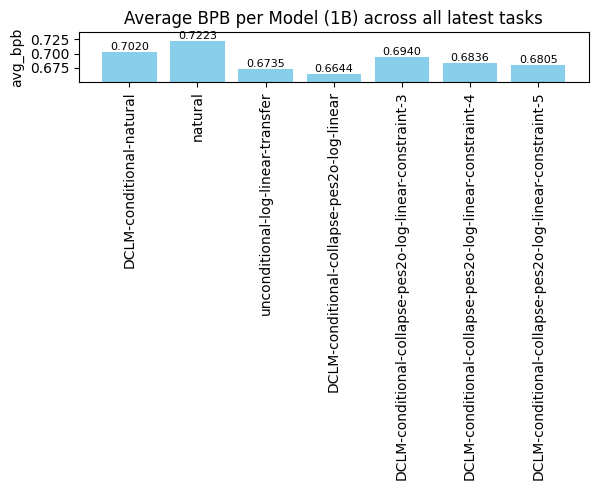

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

labels = list(desc_to_name.keys())
values = [metrics[metrics.name == name]['avg_bpb'].values[0] for desc, name in desc_to_name.items()]

# Assign colors (can customize later)
colors = ["skyblue" for _ in labels]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
bars = ax.bar(labels, values, color=colors)
ax.set_ylabel("avg_bpb")
ax.set_title("Average BPB per Model (1B) across all latest tasks")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(min(values) * 0.98, max(values) * 1.02)
plt.tight_layout()

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.4f}",       # format as needed (e.g., .2f or .3f)
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.show()



Second, compare per task improvement of a proposed mix vs a reference distribution (e.g. natural distribution)

Max task improvement: 0.23554270338383776
Worst task degradation: -0.05504819303696595
Average task improvement: 0.041840443416992196
Number of tasks that get worse: 13


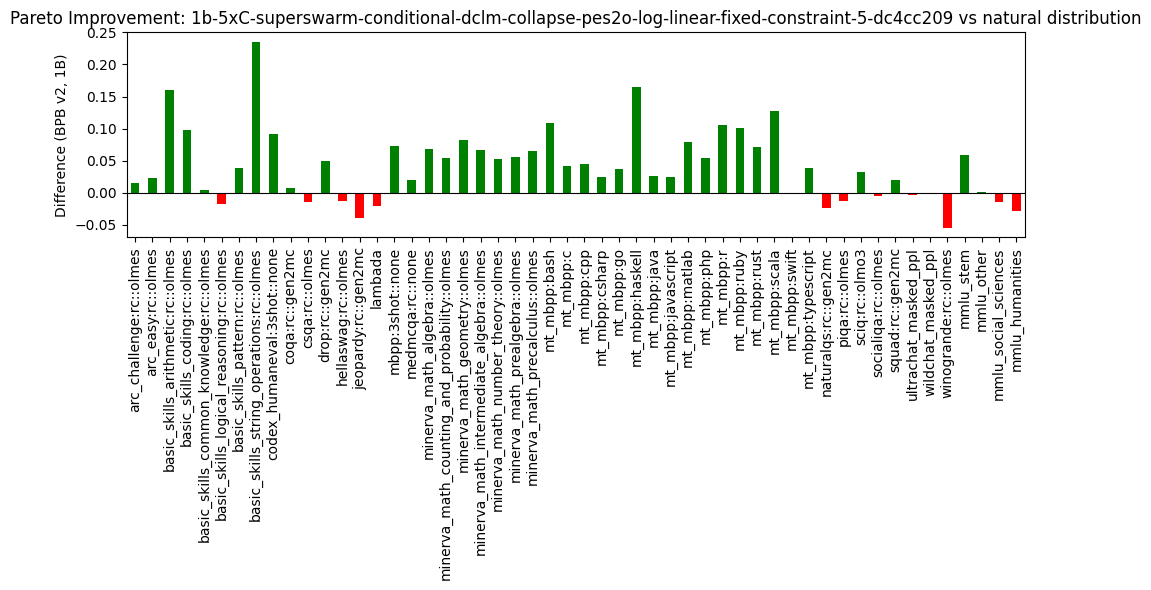

In [14]:
# reference_name and target_name need to be in metrics['name']

# reference could also be not just the natural distribution, but maybe fixed source weights with some sources having natural distribution on topics, etc.
reference_name = "1b-5xC-superswarm-v2-natural-52749eca"
target_name = "1b-5xC-superswarm-conditional-dclm-collapse-pes2o-log-linear-fixed-constraint-5-dc4cc209"

metrics_indexed = metrics.set_index('name')

task_columns = metrics.columns[3:-1]

reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(f"Max task improvement: {diff.max()}")
print(f"Worst task degradation: {diff.min()}")
print(f"Average task improvement: {diff.mean()}")
print(f"Number of tasks that get worse: {np.where(diff < 0)[0].shape[0]}")

colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: {target_name} vs natural distribution')
plt.ylabel('Difference (BPB v2, 1B)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()